# Question 1

1.1)

In [31]:
from numpy import array, zeros_like, concatenate, logspace, identity, sum, log as ln, empty, inf, inner, zeros
from numpy.random import randint, seed, normal
from numpy.linalg import cond, inv, norm
from scipy.linalg import toeplitz
from math import sqrt
from statistics import mean
from matplotlib import pyplot as plt


plt.rcParams.update({'font.family': 'DejaVu Sans', 'font.weight': 'normal', 'font.size': 22})
N_u = 500
seed(30)
u = randint(0,2,size=N_u)
all_n, all_m = array((1, 2, 2)), array((1, 1, 2))

y = zeros_like(u, dtype='float64')
for n in range(2, N_u):
    y[n] = .4*y[n-1] - .6*y[n-2] + 2*u[n-1]

def my_var(x):
    N = len(x)
    u_x = sum(x)/N
    return sum((x-u_x)**2)/(N-1)

1.2)

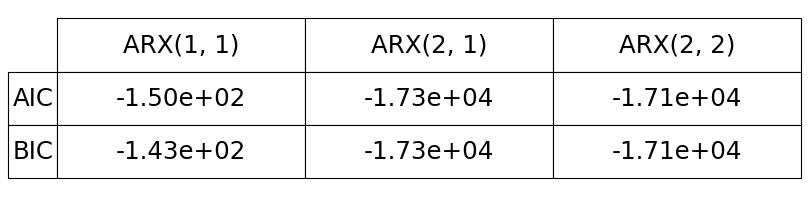

	The best option for the AIC is {n, m}={2, 1}


	The best option for the BIC is {n, m}={2, 1}


In [39]:
def ols(u, y, N, all_n, all_m):
    AIC_p, BIC_p = empty(len(all_n)), empty(len(all_n))
    AIC_best, BIC_best = inf, inf
    all_e = []
    all_theta = []

    for i, (n, m) in enumerate(zip(all_n, all_m)):
        # Observation matrix -> [N-n x n+m]
        # OBS: Due to Python has a zero-based indexing, y[k-1]-> y(k)
        H = concatenate((toeplitz(y[n-1:N-1], y[:n][::-1]), toeplitz(u[n-1:N-1], u[n-m:n][::-1])), axis=1)
        # Tikhonov regularization
        for lambda_ in logspace(0,10,base=2):
            if cond(H.T@H + (lambda_-1)*identity(n+m)) < 1e3:
                # Ordinary Least-Square (OLS)
                theta_hat = inv(H.T@H + (lambda_-1)*identity(n+m))@H.T@y[n:N]
                break
        # estimated signal
        y_hat = H @ theta_hat
        all_theta.append(theta_hat)
        # residue
        e = y[n:N] - y_hat
        all_e.append(e)
        N_e = e.size
        sigma2_e = my_var(e)
        p = m+n
        # Akaike’s Information criterion (AIC)
        AIC_p[i] = N_e*ln(sigma2_e) + 2*p
        if AIC_p[i] < AIC_best:
            AIC_best = AIC_p[i]
            y_hat_best = y_hat
            theta_hat_best = theta_hat
            iAIC_best = i # best {n, m} set
        # Bayesian Information criterion (BIC)
        BIC_p[i] = N_e*ln(sigma2_e) + p*ln(N_e)
        if BIC_p[i] < BIC_best:
            BIC_best = BIC_p[i]
    return y_hat_best, all_e, theta_hat_best, AIC_p, BIC_p, iAIC_best

N = N_u//2
y_hat, all_xi, all_theta_OLS, all_AIC, all_BIC, i_best = ols(u, y, N, all_n, all_m)


### ploting table
fig = plt.figure(figsize=(12, 3), dpi=80)
ax = fig.gca()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
col_labels = [f'ARX{n,m}' for n, m in zip(all_n, all_m)]
row_labels = ['AIC', 'BIC']
cell_tex = [[f'{i:.2e}' for i in x] for x in (all_AIC, all_BIC)]

table_ = ax.table(cellText=cell_tex, colLabels=col_labels, loc='center', cellLoc='center', rowLabels=row_labels)
table_.scale(1, 4)
plt.show()

print(f'\tThe best option for the AIC is {{n, m}}={{{all_n[i_best]}, {all_m[i_best]}}}\n\n')
print(f'\tThe best option for the BIC is {{n, m}}={{{all_n[i_best]}, {all_m[i_best]}}}')

1.3)

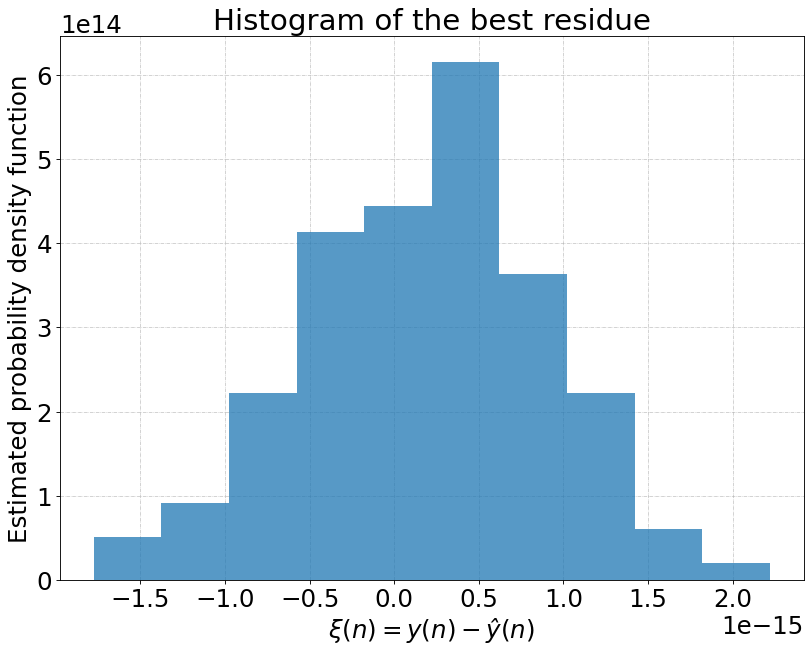

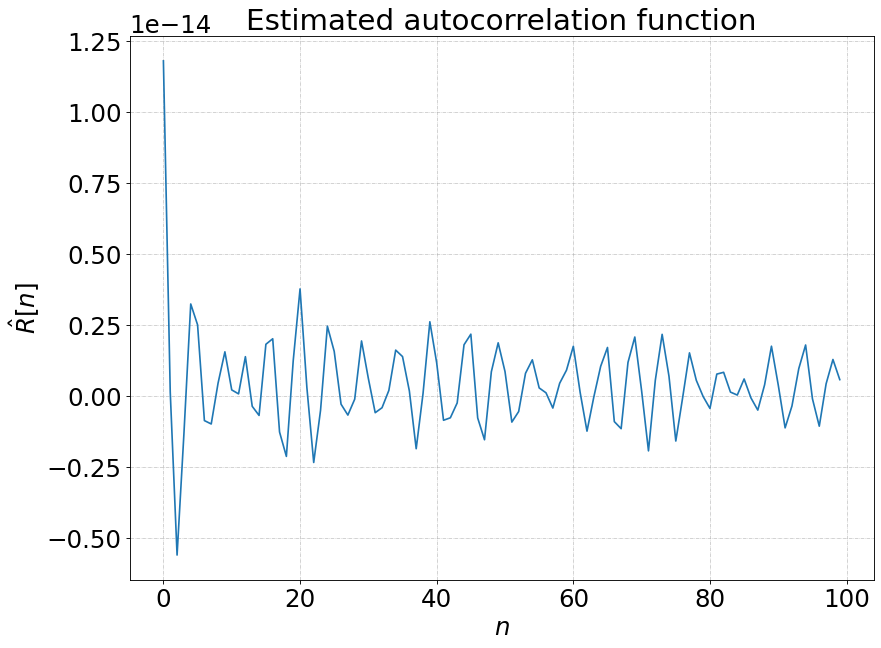

The root mean square error to the best AR(n,m) residue is:7.55e-16


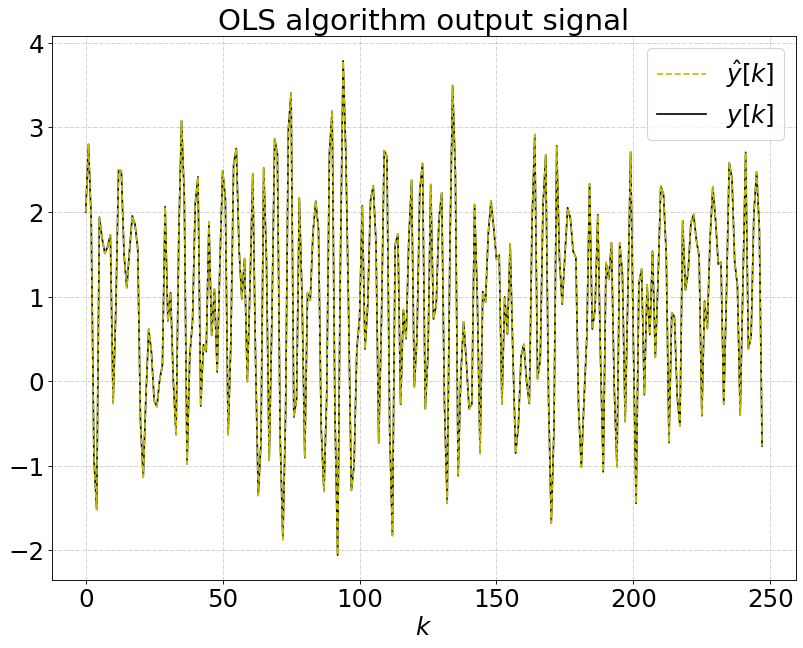

In [40]:
### histogram of the best residue
xi_best = all_xi[i_best]
n_best = all_n[i_best]

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.hist(xi_best, bins=10, density=True, alpha=0.75)
plt.xlabel(r'$\xi(n) = y(n)-ŷ(n)$')
plt.ylabel('Estimated probability density function')
plt.title('Histogram of the best residue')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

### autocorrelation function
n_max = 100
# truncate the empty part
xi_best = xi_best[4:]
N_e = xi_best.size
r = empty(n_max)
for n in range(n_max):
    r[n] = inner(xi_best[:N_e-n], xi_best[n:])/norm(xi_best)

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.plot(r)
plt.xlabel(r'$n$')
plt.ylabel(r'$\hat{R}\left[n\right]$')
plt.title('Estimated autocorrelation function')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

rmse_e = sqrt(mean(xi_best**2))
print(f'The root mean square error to the best AR(n,m) residue is:{rmse_e:.2e}')

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.plot(y_hat[:N], 'y--', zorder=2, label='$\hat{y}[k]$')
ax.plot(y[n_best:N], 'k', zorder=1, label='$y[k]$')
plt.legend(loc="upper right")
plt.xlabel(r'$k$')
plt.title('OLS algorithm output signal')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

The $ARX(n,m)$ (autoregressive with exogenous inputs) model, with $n>m$ aims to represent a mathematically a  system whose output results from delayed versions of the input and output signals plus a random process. The output signal can be written by
\begin{align}
    A(q) y\left[ n \right] = B\left[ q \right] u\left[ k \right] + v \left[ k \right],
\end{align}
where $v \left[ k \right]$ is a random noise and
\begin{align}
    A(q) = 1 - a_1q^{-1} - a_2q^{-2} \dots - a_nq^{-n}
\end{align}
and
\begin{align}
    B(q) = b_1q^{-1} + b_2q^{-2} \dots + b_mq^{-m},
\end{align}
are polynomials with arbitrary coefficients $\left\{ a_i \right\}_{i=1}^{n}$ and $\left\{ b_i \right\}_{i=1}^{m}$, respectively, and $q^{-1}$ is the delay operator. Let us define the matricial notation of the ARX(n, m) model:
\begin{align}
    y\left[ k \right] & = a_1 y\left[ k-1 \right] + a_2 y\left[ k-2 \right] + \dots + a_n y\left[ k-n \right] + b_1 u\left[ k-1 \right] + b_2 u\left[ k-2 \right] + \dots + b_n u\left[ k-m \right] + v\left[ k \right] \\
    & = \pmb{\theta}^{\mathsf{T}} \pmb{\Psi}\left[ k-1 \right] + v\left[ k \right]
\end{align}
where
\begin{align}
    \pmb{\theta} & = \left[ a_0, a_1, \cdots, a_{n-1}, b_0, b_1, \cdots, b_{m-1} \right]^{\mathsf{T}} \in \mathbb{R}^{n+m}\\
    & = \left[ \theta_0, \theta_1, \cdots, \theta_{n+m-1} \right]^{\mathsf{T}} \in \mathbb{R}^{n+m}
\end{align}
is the parameter vector, and
\begin{align}
    \pmb{\Psi}& = \left[ y\left[k-1\right], y\left[k-2\right], \cdots, y\left[k-n\right], u\left[k-1\right], u\left[k-2\right], \cdots, u\left[k-m\right] \right]^\mathsf{T} \in \mathbb{R}^{n+m}
\end{align}
is the regressor vector.

The main goal of modeling a system using the ARX(n, m) is to
- Define the set $\left\{n, m\right\}$ that produces the best result with the shortest possible length of $n$ and $m$.
- Compute the coefficients, $\pmb{\theta}$.

Let $\hat{\pmb{\theta}}$ be the estimation of $\pmb{\theta}$, which is computed using some estimation technique. The signal $\hat{y} \left[n\right] = \hat{\pmb{\theta}}^{\mathsf{T}} \pmb{\Psi}\left[ k-1 \right]$ is the estimation of $y \left[n\right]$, and $\xi \left[n\right] = y \left[n\right] - \hat{y} \left[n\right]$ is the residual signal of this estimation, that is, the difference between the actual output and the ARX(n, m) model output.

The ordinary Least-Square (OLS) is a batch solution that aims to estimate $\pmb{\theta}$ using the following cost function:
\begin{align}
    J\left( \hat{\pmb{\theta}} \right) = \sum_n^{N-1} \left( y \left[ n \right] - \hat{y}\left[ n \right] \right)^2 ,
\end{align}

where $N > 2n+m$ denotes the amount of the data available to prediction, and it shall be buffered before performing the OLS algorithm. Note that is not possible to use the whole data due to causality constrainments.

Although this method has no optimality properties associated with it, OLS is widely used in practice because of its ease of implementation, its reasonable performance, and the fact that it does not require any probabilistic assumptions about the data.Naturally, the main drawback is that no claims about the optimality of the OLS algorithm can be made. Another disadvantage is that this algorithm computes solely in offline fashion as it is needed a database of $N$ samples before estimating $\pmb{\theta}$.

The cost function can be rewritten in the matrix notation, given by
\begin{align}
    J\left( \hat{\pmb{\theta}} \right) & = \left(\mathbf{y} - \hat{\mathbf{y}}\right)^\mathsf{T}\left(\mathbf{y} - \hat{\mathbf{y}}\right) \\
    & = \left(\mathbf{y} - \mathbf{H}\hat{\pmb{\theta}}\right)^\mathsf{T}\left(\mathbf{y} - \mathbf{H}\hat{\pmb{\theta}}\right)
\end{align}
where
\begin{align}
    \mathbf{y} = \left[y\left[ n \right] + y\left[ n+1 \right] + \dots + y\left[ N-1 \right] \right]^\mathsf{T} \in \mathbb{R}^{N-n}
\end{align}
and
\begin{align}
    \mathbf{\hat{y}} = \mathbf{H}\hat{\pmb{\theta}} = \left[\hat{y}\left[ n \right] + \hat{y}\left[ n+1 \right] + \dots + \hat{y}\left[ N-1 \right] \right]^\mathsf{T} \in \mathbb{R}^{N-n},
\end{align}
being
\begin{align}
    \mathbf{H} = \begin{bmatrix}
        y[n-1] & \dots & y[0] & u[n-1] & \dots & u[n-m] \\ y[n] & \dots & y[1] & u[n] & \dots & u[n-m+1] \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ y[N-2] &&\dots&&& u[N-m-1] \end{bmatrix} \in \mathbb{R}^{N-n \times n+m}
\end{align}
the observation matrix. The observation matrix in computed in the line `11` of my code.

the cost function can be rewritten as
\begin{align}
    J\left( \hat{\pmb{\theta}} \right) & = \mathbf{y}^{\mathsf{T}}\mathbf{y} - \mathbf{y}^{\mathsf{T}}\mathbf{H}\hat{\pmb{\theta}} - \hat{\pmb{\theta}}^{\mathsf{T}}\mathbf{H}^{\mathsf{T}}\mathbf{y} + \hat{\pmb{\theta}}^{\mathsf{T}}\mathbf{H}^{\mathsf{T}}\mathbf{H}\hat{\pmb{\theta}} \\
    & = \mathbf{y}^{\mathsf{T}}\mathbf{y} - 2\mathbf{y}^{\mathsf{T}}\mathbf{H}\hat{\pmb{\theta}} + \hat{\pmb{\theta}}^{\mathsf{T}}\mathbf{H}^{\mathsf{T}}\mathbf{H}\hat{\pmb{\theta}},
\end{align}
where the second equation follows that $\mathbf{y}^{\mathsf{T}}\mathbf{H}\hat{\pmb{\theta}} = \hat{\pmb{\theta}}^{\mathsf{T}}\mathbf{H}^{\mathsf{T}}\mathbf{y} \in \mathbb{R}$.

The estimated parameter vector that minimizes the cost function is the one that sets its gradient to zero, that is,
\begin{align}
    \frac{\partial J\left( \hat{\pmb{\theta}} \right)}{\partial \hat{\pmb{\theta}}} = - 2\mathbf{H}^{\mathsf{T}}\mathbf{y} + 2 \mathbf{H}^{\mathsf{T}}\mathbf{H}\hat{\pmb{\theta}} = 0.
\end{align}
Isolating $\hat{\pmb{\theta}}$, we have that
\begin{align}
    \hat{\pmb{\theta}} & = (\mathbf{H}^{\mathsf{T}}\mathbf{H})^{-1}\mathbf{H}^{\mathsf{T}} \mathbf{y}\\
    & = \mathbf{H}^\dagger \mathbf{y}
\end{align}
where $\mathbf{H}^\dagger = (\mathbf{H}^{\mathsf{T}}\mathbf{H})^{-1}\mathbf{H}^{\mathsf{T}}$ is the pseudo inverse of $\mathbf{H}$, also called the left inverse because $\mathbf{H}$ is a tall matrix since $N-n > n+m$.

Sometimes, when $\mathbf{H}^{\mathsf{T}}\mathbf{H}$ is not well-conditioned, one can perform the Tikhonov's regularization, which consists in swerving the basis vectors of the column space of $\mathbf{H}^{\mathsf{T}}\mathbf{H}$. In a hyperplane visualization, this procedure spans all the space achievable by $\mathbf{H}^{\mathsf{T}}\mathbf{H}$, making it a full-rank linear transformation. This swerving is reached simply adding $\lambda\mathbf{I}$ to $\mathbf{H}^{\mathsf{T}}\mathbf{H}$, where $\mathbf{I} \in \mathbb{R}^{n+m \times n+m}$ is the identity matrix and $\lambda \in \mathbb{R}$ is a hyperparameter that shall be increasingly adjusted until reaching a sensible condition number. The Tikhonov's regularization is performed from the line `13` up to `17` in my code.

#### Geometrical interpretation of the OLS algorithm

Let us review the OLS method from a geometrical perspective. Consider that
\begin{align}
    \mathbf{H} = \begin{bmatrix}
        \mathbf{h}_{1} & \mathbf{h}_{2} & \dots & \mathbf{h}_{n+m-1}\end{bmatrix}.
\end{align}
Hence, the estimated vector
\begin{align}
    \hat{\mathbf{y}} = \sum_{i=0}^{n+m-1} \hat{\theta}_i \mathbf{h}_i
\end{align}
can be thought as the linear combination of the column vectors of $\mathbf{H}$. Substituting this representation into the cost function, we have that
\begin{align}
    J\left( \hat{\pmb{\theta}} \right) & = \left(\mathbf{y} - \hat{\mathbf{y}}\right)^\mathsf{T}\left(\mathbf{y} - \hat{\mathbf{y}}\right) \\
    & = \left\lVert \mathbf{y} - \hat{\mathbf{y}} \right\rVert^2 \\
    & = \left\lVert \mathbf{y} - \sum_{i=0}^{n+m-1} \hat{\theta}_i \mathbf{h}_i \right\rVert^2,
\end{align}
We now perceive that the OLS method attempts to minimize the square distance between the actual data, $\mathbf{y}$, and the vector $\hat{\mathbf{y}}=\sum_{i=0}^{n+m-1} \theta_i\mathbf{h}_i$. It turns out that $\mathbf{y}$ can lie anywhere in $\mathbb{R}^{N-n}$, whereas $\hat{\mathbf{y}}$ lies, at most, in a $m+n$-dimensional subspace of $\mathbb{R}^{N-n}$. When each of the columns vector of $\mathbf{H}$ spans a new dimension, the dimensionality of $S^{n+m}$ is, indeed, $n+m$. Assuming that it is true due to the Tikhonov's regularization, this subspace is hereafter denoted by $S^{n+m}$. Since, $N-n \gg n+m$, $\hat{\mathbf{y}}$ will never be able to estimate $\mathbf{y}$ precisely. For the sake of clarity, suppose that $N-n = 3$ and $n+m = 2$. The following Figure represents the plan that the columns vectors of $\mathbf{H}$ spans (example is from Kay, S.M., 1993. Fundamentals of statistical signal processing: estimation theory. Prentice-Hall, Inc..).
![](https://i.ibb.co/HtRGgKr/Screenshot-from-2022-03-09-01-15-40.png)

The estimated vector is (to make sense with our notation, consider that $\mathbf{x}$ is $\mathbf{y}$, $\hat{\mathbf{s}}$ is $\hat{\mathbf{y}}$, and $\mathbf{e}$ is $\mathbf{\xi}$)
![](https://i.ibb.co/64knwZr/Screenshot-from-2022-03-09-01-32-31.png)

From this image, we see that
\begin{align}
    \mathbf{\xi} \perp S^{n+m},
\end{align}
as $\hat{\mathbf{y}} \in S^{n+m}$, $\mathbf{\xi} \perp \hat{\mathbf{y}}$. That is, **the residual vector is orthogonal to the estimated output vector**. Let us analyse the mean square value (that is, the power) of the residual vector at the $k$-th sample. Consider that:

\begin{align}
    \xi \left[ k \right] = y \left[ k \right] - \hat{\pmb{\theta}}^{\mathsf{T}} \hat{\pmb{\Psi}}\left[ k-1 \right],
\end{align}
where
\begin{align}
    \hat{\pmb{\Psi}}\left[ k-1 \right]& = \left[ \hat{y}\left[k-1\right], \hat{y}\left[k-2\right], \cdots, \hat{y}\left[k-n\right], u\left[k-1\right], u\left[k-2\right], \cdots, u\left[k-m\right] \right]^\mathsf{T} \in \mathbb{R}^{n+m},
\end{align}
then
\begin{align}
    \frac{\partial\mathbb{E}\left\{ \xi^2\left[ k \right] \right\}}{\partial \pmb{\theta}} = \mathbb{E}\left\{2 \xi\left[ k \right] \frac{\partial \xi\left[ k \right] }{\partial \pmb{\theta}}\right\},
\end{align}
where $$

On recursive estimation methods that the parameter vector approaches to the OLS result in permanent regime, it is possible to derive, from the previous Equation, that
\begin{align}
    R_\xi \left( \tau \right) = \mathbb{E}\left\{ \xi \left[ k \right] \xi \left[ k - \tau \right] \right\} = \left\{ \begin{array}{cc}
        1 & \mathrm{if}\;\tau = 0 \\
        0 & \mathrm{Otherwise} \end{array}. \right.
\end{align}
The LMS (Least Mean Square) algorithm is one example that it is easy to show that. Unfortunately, I do not know how to manipulate mathematically the residue of the batch-solution OLS algorithm in order to prove it. That is the limit about my theoretical knowledge of the OLS method.

The result on the question `1.3` shows exactly that the estimated autocorrelation function of $\xi \left[ k \right]$ is a delta Kronecker. In other words, the $\xi \left[ k \right]$ is a White random process. Furthermore, it is possible to notice that the probability density function (PDF) of $\xi \left[ k \right]$ approaches to a Gaussian process, making a sensible supposition that $\xi \left[ k \right]$ is AWGN (Additive White Gaussian noise).

#### Question 1.4

**The stochastic gradient, also called LMS (Least Mean Squares)**

Akaike's Information criterion (AIC):
	AIC(1,1) = -2.50e+03
	AIC(2,1) = -2.86e+03
	AIC(2,2) = -2.62e+03
Bayesian Information criterion (BIC):
	BIC(1,1) = -2.49e+03
	BIC(2,1) = -2.85e+03
	BIC(2,2) = -2.61e+03
	The best option for the AIC is {n, m}={2, 1}


	The best option for the BIC is {n, m}={2, 1}


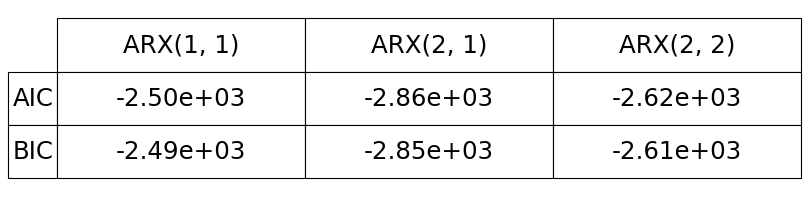

	The best option for the AIC is {n, m}={2, 1}


	The best option for the BIC is {n, m}={2, 1}


In [45]:
def lms(u, y, N, all_n, all_m):
    all_xi, all_theta = [], []
    AIC_p, BIC_p = empty(len(all_n)), empty(len(all_n))
    AIC_best, BIC_best = inf, inf
    # step learning
    mu = .03

    for i, (n, m) in enumerate(zip(all_n, all_m)):
        # initializing the coefficient vector, theta[0]
        theta_hat = zeros((n+m, N-n+1), dtype='float64')
        # initializing the residual signal
        xi = zeros(N-1, dtype='float64')
        y_hat = []
        for k in range(N-n):
            # input vector
            x = concatenate((y[k:n+k][::-1], u[n-m+k:n+k][::-1]))
            # estimated output signal
            y_hat_k = inner(x, theta_hat[:,k])
            y_hat.append(y_hat_k)
            # residual signal
            xi[k] = y[k] - y_hat_k
            # LMS algorithm
            delta_theta = 2*mu*xi[k]*x
            theta_hat[:,k+1] = theta_hat[:,k] + delta_theta

        # saving residual and theta
        all_xi.append(xi)
        all_theta.append(theta_hat)
        # cut off the transitory part
        sigma2_xi = my_var(xi[100:])
        # Akaike’s Information criterion (AIC)
        p = m+n
        N_xi = xi.size
        AIC_p[i] = N_xi*ln(sigma2_xi) + 2*p
        if AIC_p[i] < AIC_best:
            AIC_best = AIC_p[i]
            y_hat_best = array(y_hat)
            i_best = i # best {n, m} set
        # Bayesian Information criterion (BIC)
        BIC_p[i] = N_xi*ln(sigma2_xi) + p*ln(N_xi)
        if BIC_p[i] < BIC_best:
            BIC_best = BIC_p[i]
    return y_hat_best, all_xi, all_theta, AIC_p, BIC_p, i_best

y_hat_best, all_xi, all_theta, all_AIC, all_BIC, i_best = lms(u, y, N, all_n, all_m)

### ploting table
fig = plt.figure(figsize=(12, 3), dpi=80)
ax = fig.gca()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
col_labels = [f'ARX{n,m}' for n, m in zip(all_n, all_m)]
row_labels = ['AIC', 'BIC']
cell_tex = [[f'{i:.2e}' for i in x] for x in (all_AIC, all_BIC)]

table_ = ax.table(cellText=cell_tex, colLabels=col_labels, loc='center', cellLoc='center', rowLabels=row_labels)
table_.scale(1, 4)
plt.show()

print(f'\tThe best option for the AIC is {{n, m}}={{{all_n[i_best]}, {all_m[i_best]}}}\n\n')
print(f'\tThe best option for the BIC is {{n, m}}={{{all_n[i_best]}, {all_m[i_best]}}}')

In [24]:
xi_best = all_xi[iAIC_best]
theta_hat_best_LMS = all_theta_LMS[iAIC_best]
theta_hat_best_OLS = all_theta_OLS[iAIC_best]

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.plot(xi_best)
plt.xlabel(r'$k$')
plt.ylabel(r'$\xi\left[k\right]$')
plt.title('Residual estimation signal')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()
rmse_xi = sqrt(mean(xi_best[100:]**2))
print(f'The root mean square error to the best AR(n,m) residue is:{rmse_xi:.2e}')


fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.plot(theta_hat_best_LMS[0,:], theta_hat_best_LMS[1,:], 'x-', markersize=8, label='LMS')
ax.plot(theta_hat_best_OLS[0], theta_hat_best_OLS[1], 'x-', markersize=16, markeredgewidth=6, label='OLS')
plt.legend(loc="upper right")
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Comparision between the OLS and the LMS algorithm')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.plot(y_hat_best[n_best:N], 'y--', zorder=2, label='$\hat{y}[k]$')
ax.plot(y[n_best:N], 'k', zorder=1, label='$y[k]$')
plt.legend(loc="upper right")
plt.xlabel(r'$k$')
plt.title('LMS algorithm output signal')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

NameError: name 'all_theta_OLS' is not defined